In [1]:
import matplotlib.pyplot as plt
from pysnowflake.simple import Session

/usr/local/lib/python3.7/dist-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (4.0.1), please install a version that adheres to: 'pyarrow<3.1.0,>=3.0.0; extra == "pandas"'
  _expected_pyarrow_version,


In [6]:
def pull(token,date,model_name):
    with Session() as sess:
        query = """ select distinct
    *
    from (
             select payment_token,
                    unit_token,
                    amount_base_unit_usd,
                    PAYMENT_TRX_RECOGNIZED_AT,
                    row_number() over (partition by unit_token order by PAYMENT_TRX_RECOGNIZED_AT desc) as payment_cnt
             from APP_BI.PENTAGON.FACT_PAYMENT_TRANSACTIONS
             where PAYMENT_TRX_RECOGNIZED_AT >= DATEADD(DAY, -90, '{date}')
               and PAYMENT_TRX_RECOGNIZED_AT <  '{date}'
               and unit_token = '{token}'
         ) fpt
     left join
        (select
        modelname,
        eventkey,
        score,
        dmeta_datestring
        from APP_RISK.APP_RISK.RISKARBITER_SCORED_EVENT
             where
                   dmeta_datestring >= DATEADD(DAY, -90, '{date}')
                   and DMETA_DATESTRING< '{date}'
                   and
                   MODELNAME= '{model_name}'
        ) s
         on fpt.payment_token = s.eventkey

        left join (
        select
        payment_token
        ,chargeback_cents/100 as chargeback_dllr
        ,loss_cents/100 as loss_dllr
        from APP_RISK.APP_RISK.CHARGEBACK_LOSS
        where PAYMENT_CREATED_AT >= DATEADD(DAY, -90, '{date}')
        and PAYMENT_CREATED_AT < '{date}'
        ) cb
         on fpt.payment_token = cb.PAYMENT_TOKEN

         where fpt.payment_cnt <= 90
         order by PAYMENT_TRX_RECOGNIZED_AT asc

        """.format(token = token, date = date, model_name = model_name);
        return sess.execute(query)


In [3]:
#Credit risk models below for new sellers and existing sellers. New seller is <180 days

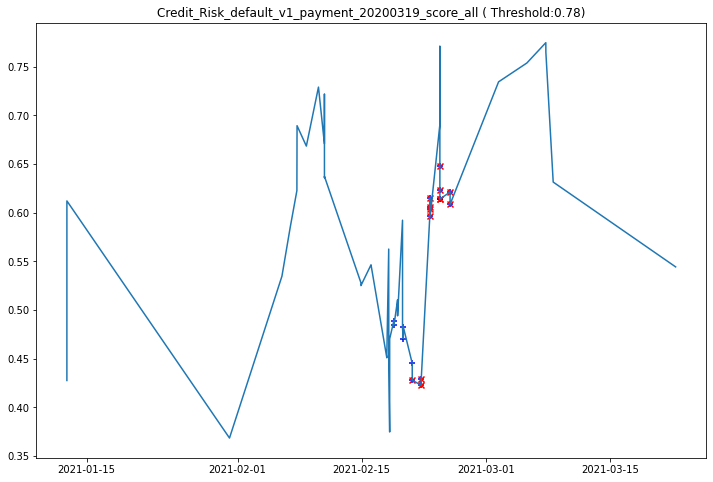

In [5]:
df['loss_dllr'] = df['loss_dllr'].astype('float',)
df2 = df[df.chargeback_dllr>0]
df3 = df[df.loss_dllr >0]

plt.figure(figsize=(12, 8))
plt.title("Credit_Risk_default_v1_payment_20200319_score_all ( Threshold:0.78)")
plt.plot(df['payment_trx_recognized_at'], df['score'])
plt.scatter(df2['payment_trx_recognized_at'], df2['score'], marker='+',color = 'b')
plt.scatter(df3['payment_trx_recognized_at'], df3['score'], marker='x',color = 'r')
plt.axhline(y=0.78, color='y', linestyle='-')

In [6]:
#Credit risk model for existing seller, score from the rule above < 2900000 is good 
#(per https://knowledge-ui.sqprod.co/r/rule_details/Credit_Risk_high_gpv_model_existing_seller_DAR_20200520/configs)
df = pull('LVZE61CG7TG3M', '2021-03-31', 'credit_risk_high_gpv_model_DAR_all')

In [7]:
df

,payment_token,unit_token,amount_base_unit_usd,payment_trx_recognized_at,payment_cnt,modelname,eventkey,score,dmeta_datestring,payment_token,chargeback_dllr,loss_dllr
0,5GB6Qbof74Tks0SmlYUVncYPuaB,LVZE61CG7TG3M,247865,2021-01-12 18:24:09,59,credit_risk_high_gpv_model_DAR_all,5GB6Qbof74Tks0SmlYUVncYPuaB,2.053267e+05,2021-01-12,None,None,None
1,PPsqXwgbd6VfBlD6Im3xYmEruaB,LVZE61CG7TG3M,165800,2021-01-12 18:26:22,58,credit_risk_high_gpv_model_DAR_all,PPsqXwgbd6VfBlD6Im3xYmEruaB,3.788673e+05,2021-01-12,None,None,None
2,VoTmGQBntWX5b1Cz4rsjoH12uaB,LVZE61CG7TG3M,17200,2021-01-31 02:14:53,57,credit_risk_high_gpv_model_DAR_all,VoTmGQBntWX5b1Cz4rsjoH12uaB,3.349808e+05,2021-01-31,None,None,None
3,7PdYJp2LsX1LGL2njDg2gfShuaB,LVZE61CG7TG3M,325700,2021-02-06 00:06:42,56,credit_risk_high_gpv_model_DAR_all,7PdYJp2LsX1LGL2njDg2gfShuaB,6.313447e+05,2021-02-06,None,None,None
4,TTp4Pm10QvxIHtZpq0KfKfOauaB,LVZE61CG7TG3M,176200,2021-02-06 22:26:33,55,credit_risk_high_gpv_model_DAR_all,TTp4Pm10QvxIHtZpq0KfKfOauaB,7.007417e+05,2021-02-06,None,None,None
5,VmyaqXU8OlxZD4x7zNSqbCRdvaB,LVZE61CG7TG3M,132500,2021-02-07 16:35:05,54,credit_risk_high_gpv_model_DAR_all,VmyaqXU8OlxZD4x7zNSqbCRdvaB,7.462548e+05,2021-02-07,None,None,None
6,zfhTUZtQdBSC1yRFcfM9XbMfvaB,LVZE61CG7TG3M,175000,2021-02-07 16:37:32,53,credit_risk_high_gpv_model_DAR_all,zfhTUZtQdBSC1yRFcfM9XbMfvaB,7.482101e+05,2021-02-07,None,None,None
7,FGmS0ApojN9omDGoGUi1IHKhvaB,LVZE61CG7TG3M,133145,2021-02-07 16:49:25,52,credit_risk_high_gpv_model_DAR_all,FGmS0ApojN9omDGoGUi1IHKhvaB,6.126019e+05,2021-02-07,None,None,None
8,JkWZPeKW28GuExgvGN2qlKXeuaB,LVZE61CG7TG3M,164200,2021-02-07 16:51:38,51,credit_risk_high_gpv_model_DAR_all,JkWZPeKW28GuExgvGN2qlKXeuaB,5.681440e+05,2021-02-07,None,None,None
9,DpIMxQjN380NRNL1KyFuc9gXvaB,LVZE61CG7TG3M,215900,2021-02-07 16:58:20,50,credit_risk_high_gpv_model_DAR_all,DpIMxQjN380NRNL1KyFuc9gXvaB,6.891016e+05,2021-02-07,None,None,None


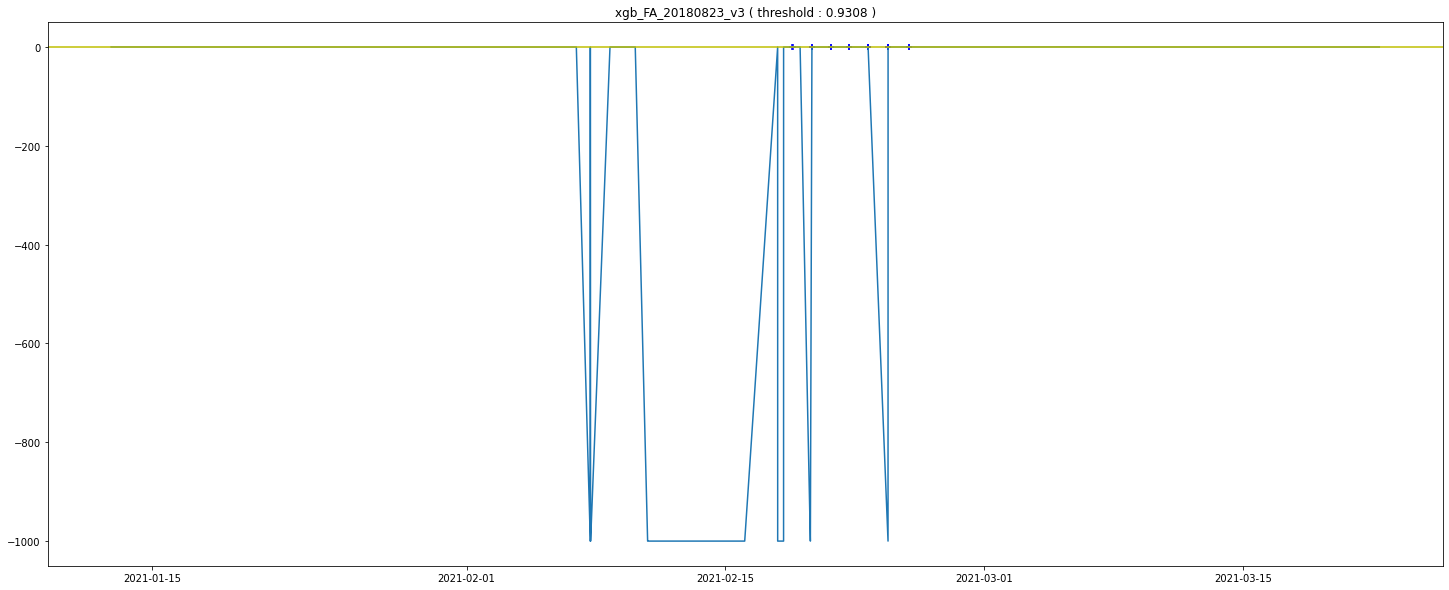

In [8]:
#BF model  - Lower threshold is 0.7 (*but is used only for 1K and above)
df_fa = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_FA_20180823_v3')
df_fa['loss_dllr'] = df_fa['loss_dllr'].astype('float',)

df_fa1= df_fa[df_fa['payment_trx_recognized_at']> '2020-12-31 11:59:59']
df_fa2 = df_fa1[df_fa1.chargeback_dllr>0]
df_fa3 = df_fa1[df_fa1.loss_dllr >0]

plt.figure(figsize=(25, 10))
plt.title("xgb_FA_20180823_v3 ( threshold : 0.9308 )")
plt.plot(df_fa1['payment_trx_recognized_at'], df_fa1['score'])
plt.scatter(df_fa2['payment_trx_recognized_at'], df_fa2['score'], marker='+',color = 'b')
#plt.scatter(df_bf3['payment_trx_recognized_at'], df_bf3['score'], marker='x',color = 'r')

plt.axhline(y=0.9308, color='y', linestyle='-')

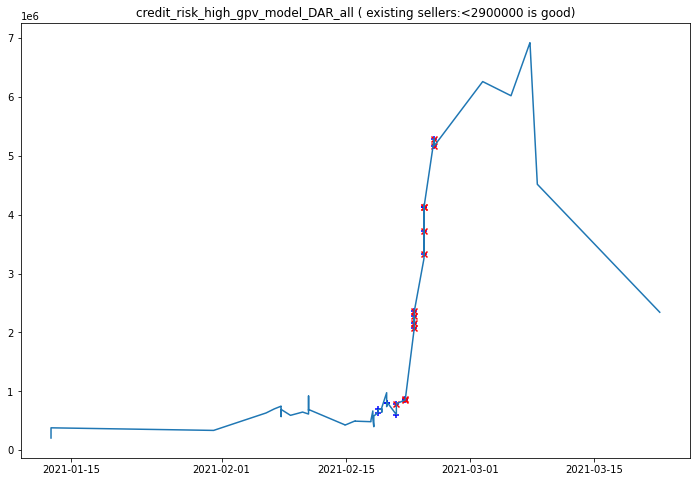

In [9]:
df['loss_dllr'] = df['loss_dllr'].astype('float',)
df2 = df[df.chargeback_dllr>0]
df3 = df[df.loss_dllr >0]

plt.figure(figsize=(12, 8))
plt.title("credit_risk_high_gpv_model_DAR_all ( existing sellers:<2900000 is good)")
plt.plot(df['payment_trx_recognized_at'], df['score'])
plt.scatter(df2['payment_trx_recognized_at'], df2['score'], marker='+',color = 'b')
plt.scatter(df3['payment_trx_recognized_at'], df3['score'], marker='x',color = 'r')
plt.axhline(y=2900000, color='y', linestyle='-')

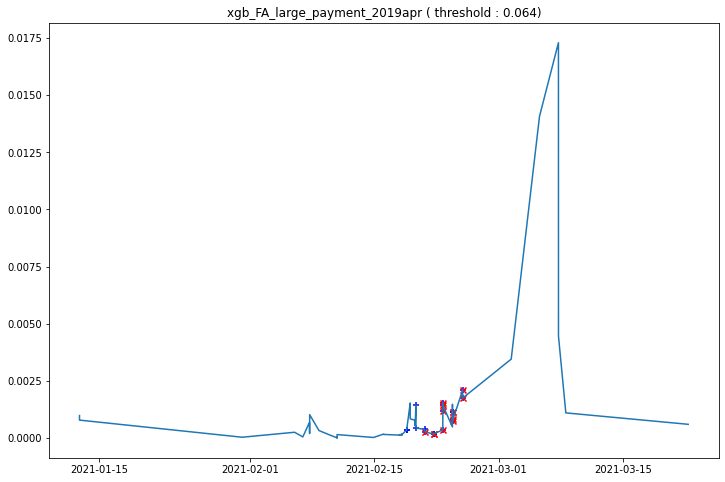

In [10]:
#FA model  - Lower threshold is 0.064
df = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_FA_large_payment_2019apr')
df['loss_dllr'] = df['loss_dllr'].astype('float',)
df2 = df[df.chargeback_dllr>0]
df3 = df[df.loss_dllr >0]

plt.figure(figsize=(12, 8))
plt.title("xgb_FA_large_payment_2019apr ( threshold : 0.064)")
plt.plot(df['payment_trx_recognized_at'], df['score'])
plt.scatter(df2['payment_trx_recognized_at'], df2['score'], marker='+',color = 'b')
plt.scatter(df3['payment_trx_recognized_at'], df3['score'], marker='x',color = 'r')

In [11]:
df

,payment_token,unit_token,amount_base_unit_usd,payment_trx_recognized_at,payment_cnt,modelname,eventkey,score,dmeta_datestring,payment_token,chargeback_dllr,loss_dllr
0,5GB6Qbof74Tks0SmlYUVncYPuaB,LVZE61CG7TG3M,247865,2021-01-12 18:24:09,59,xgb_FA_large_payment_2019apr,5GB6Qbof74Tks0SmlYUVncYPuaB,0.000982,2021-01-12,None,None,NaN
1,PPsqXwgbd6VfBlD6Im3xYmEruaB,LVZE61CG7TG3M,165800,2021-01-12 18:26:22,58,xgb_FA_large_payment_2019apr,PPsqXwgbd6VfBlD6Im3xYmEruaB,0.000784,2021-01-12,None,None,NaN
2,VoTmGQBntWX5b1Cz4rsjoH12uaB,LVZE61CG7TG3M,17200,2021-01-31 02:14:53,57,xgb_FA_large_payment_2019apr,VoTmGQBntWX5b1Cz4rsjoH12uaB,0.000035,2021-01-31,None,None,NaN
3,7PdYJp2LsX1LGL2njDg2gfShuaB,LVZE61CG7TG3M,325700,2021-02-06 00:06:42,56,xgb_FA_large_payment_2019apr,7PdYJp2LsX1LGL2njDg2gfShuaB,0.000253,2021-02-06,None,None,NaN
4,TTp4Pm10QvxIHtZpq0KfKfOauaB,LVZE61CG7TG3M,176200,2021-02-06 22:26:33,55,xgb_FA_large_payment_2019apr,TTp4Pm10QvxIHtZpq0KfKfOauaB,0.000049,2021-02-06,None,None,NaN
5,VmyaqXU8OlxZD4x7zNSqbCRdvaB,LVZE61CG7TG3M,132500,2021-02-07 16:35:05,54,xgb_FA_large_payment_2019apr,VmyaqXU8OlxZD4x7zNSqbCRdvaB,0.000688,2021-02-07,None,None,NaN
6,zfhTUZtQdBSC1yRFcfM9XbMfvaB,LVZE61CG7TG3M,175000,2021-02-07 16:37:32,53,xgb_FA_large_payment_2019apr,zfhTUZtQdBSC1yRFcfM9XbMfvaB,0.000251,2021-02-07,None,None,NaN
7,FGmS0ApojN9omDGoGUi1IHKhvaB,LVZE61CG7TG3M,133145,2021-02-07 16:49:25,52,xgb_FA_large_payment_2019apr,FGmS0ApojN9omDGoGUi1IHKhvaB,0.000248,2021-02-07,None,None,NaN
8,JkWZPeKW28GuExgvGN2qlKXeuaB,LVZE61CG7TG3M,164200,2021-02-07 16:51:38,51,xgb_FA_large_payment_2019apr,JkWZPeKW28GuExgvGN2qlKXeuaB,0.000197,2021-02-07,None,None,NaN
9,DpIMxQjN380NRNL1KyFuc9gXvaB,LVZE61CG7TG3M,215900,2021-02-07 16:58:20,50,xgb_FA_large_payment_2019apr,DpIMxQjN380NRNL1KyFuc9gXvaB,0.000689,2021-02-07,None,None,NaN


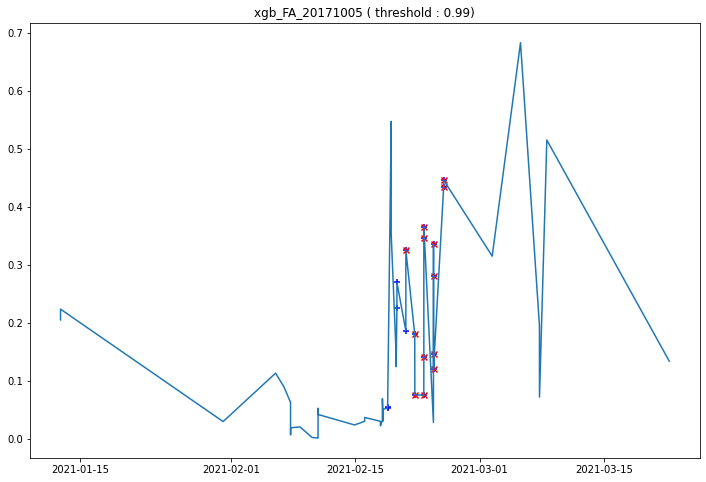

In [12]:

#FA model 0.99
df = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_FA_20171005')
df['loss_dllr'] = df['loss_dllr'].astype('float',)
df2 = df[df.chargeback_dllr>0]
df3 = df[df.loss_dllr >0]

plt.figure(figsize=(12, 8))
plt.title("xgb_FA_20171005 ( threshold : 0.99)")
plt.plot(df['payment_trx_recognized_at'], df['score'])
plt.scatter(df2['payment_trx_recognized_at'], df2['score'], marker='+',color = 'b')
plt.scatter(df3['payment_trx_recognized_at'], df3['score'], marker='x',color = 'r')

In [13]:
df

,payment_token,unit_token,amount_base_unit_usd,payment_trx_recognized_at,payment_cnt,modelname,eventkey,score,dmeta_datestring,payment_token,chargeback_dllr,loss_dllr
0,5GB6Qbof74Tks0SmlYUVncYPuaB,LVZE61CG7TG3M,247865,2021-01-12 18:24:09,59,xgb_FA_20171005,5GB6Qbof74Tks0SmlYUVncYPuaB,0.205505,2021-01-12,None,None,NaN
1,PPsqXwgbd6VfBlD6Im3xYmEruaB,LVZE61CG7TG3M,165800,2021-01-12 18:26:22,58,xgb_FA_20171005,PPsqXwgbd6VfBlD6Im3xYmEruaB,0.224133,2021-01-12,None,None,NaN
2,VoTmGQBntWX5b1Cz4rsjoH12uaB,LVZE61CG7TG3M,17200,2021-01-31 02:14:53,57,xgb_FA_20171005,VoTmGQBntWX5b1Cz4rsjoH12uaB,0.030260,2021-01-31,None,None,NaN
3,7PdYJp2LsX1LGL2njDg2gfShuaB,LVZE61CG7TG3M,325700,2021-02-06 00:06:42,56,xgb_FA_20171005,7PdYJp2LsX1LGL2njDg2gfShuaB,0.113723,2021-02-06,None,None,NaN
4,TTp4Pm10QvxIHtZpq0KfKfOauaB,LVZE61CG7TG3M,176200,2021-02-06 22:26:33,55,xgb_FA_20171005,TTp4Pm10QvxIHtZpq0KfKfOauaB,0.090603,2021-02-06,None,None,NaN
5,VmyaqXU8OlxZD4x7zNSqbCRdvaB,LVZE61CG7TG3M,132500,2021-02-07 16:35:05,54,xgb_FA_20171005,VmyaqXU8OlxZD4x7zNSqbCRdvaB,0.063501,2021-02-07,None,None,NaN
6,zfhTUZtQdBSC1yRFcfM9XbMfvaB,LVZE61CG7TG3M,175000,2021-02-07 16:37:32,53,xgb_FA_20171005,zfhTUZtQdBSC1yRFcfM9XbMfvaB,0.008895,2021-02-07,None,None,NaN
7,FGmS0ApojN9omDGoGUi1IHKhvaB,LVZE61CG7TG3M,133145,2021-02-07 16:49:25,52,xgb_FA_20171005,FGmS0ApojN9omDGoGUi1IHKhvaB,0.007415,2021-02-07,None,None,NaN
8,JkWZPeKW28GuExgvGN2qlKXeuaB,LVZE61CG7TG3M,164200,2021-02-07 16:51:38,51,xgb_FA_20171005,JkWZPeKW28GuExgvGN2qlKXeuaB,0.008790,2021-02-07,None,None,NaN
9,DpIMxQjN380NRNL1KyFuc9gXvaB,LVZE61CG7TG3M,215900,2021-02-07 16:58:20,50,xgb_FA_20171005,DpIMxQjN380NRNL1KyFuc9gXvaB,0.012656,2021-02-07,None,None,NaN


In [15]:
df

,payment_token,unit_token,amount_base_unit_usd,payment_trx_recognized_at,payment_cnt,modelname,eventkey,score,dmeta_datestring,payment_token,chargeback_dllr,loss_dllr
0,5GB6Qbof74Tks0SmlYUVncYPuaB,LVZE61CG7TG3M,247865,2021-01-12 18:24:09,59,None,None,NaN,None,None,None,NaN
1,PPsqXwgbd6VfBlD6Im3xYmEruaB,LVZE61CG7TG3M,165800,2021-01-12 18:26:22,58,None,None,NaN,None,None,None,NaN
2,VoTmGQBntWX5b1Cz4rsjoH12uaB,LVZE61CG7TG3M,17200,2021-01-31 02:14:53,57,None,None,NaN,None,None,None,NaN
3,7PdYJp2LsX1LGL2njDg2gfShuaB,LVZE61CG7TG3M,325700,2021-02-06 00:06:42,56,None,None,NaN,None,None,None,NaN
4,TTp4Pm10QvxIHtZpq0KfKfOauaB,LVZE61CG7TG3M,176200,2021-02-06 22:26:33,55,None,None,NaN,None,None,None,NaN
5,VmyaqXU8OlxZD4x7zNSqbCRdvaB,LVZE61CG7TG3M,132500,2021-02-07 16:35:05,54,xgb_FA_cp_20180321,VmyaqXU8OlxZD4x7zNSqbCRdvaB,0.000904,2021-02-07,None,None,NaN
6,zfhTUZtQdBSC1yRFcfM9XbMfvaB,LVZE61CG7TG3M,175000,2021-02-07 16:37:32,53,xgb_FA_cp_20180321,zfhTUZtQdBSC1yRFcfM9XbMfvaB,0.000162,2021-02-07,None,None,NaN
7,FGmS0ApojN9omDGoGUi1IHKhvaB,LVZE61CG7TG3M,133145,2021-02-07 16:49:25,52,xgb_FA_cp_20180321,FGmS0ApojN9omDGoGUi1IHKhvaB,0.000105,2021-02-07,None,None,NaN
8,JkWZPeKW28GuExgvGN2qlKXeuaB,LVZE61CG7TG3M,164200,2021-02-07 16:51:38,51,xgb_FA_cp_20180321,JkWZPeKW28GuExgvGN2qlKXeuaB,0.000109,2021-02-07,None,None,NaN
9,DpIMxQjN380NRNL1KyFuc9gXvaB,LVZE61CG7TG3M,215900,2021-02-07 16:58:20,50,xgb_FA_cp_20180321,DpIMxQjN380NRNL1KyFuc9gXvaB,0.000021,2021-02-07,None,None,NaN


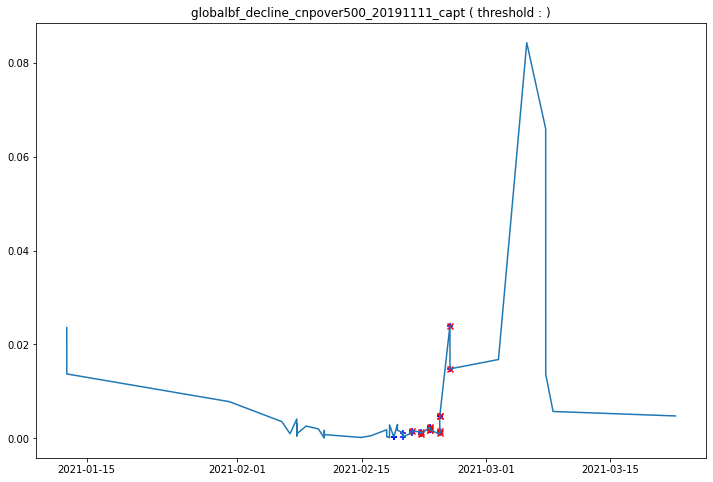

In [28]:

#BF model for card present - threshold - 0.7
df = pull('LVZE61CG7TG3M', '2021-03-31', 'globalbf_decline_cnpover500_20191111_capt')
df['loss_dllr'] = df['loss_dllr'].astype('float',)
df2 = df[df.chargeback_dllr>0]
df3 = df[df.loss_dllr >0]

plt.figure(figsize=(12, 8))
plt.title("globalbf_decline_cnpover500_20191111_capt ( threshold : )")
plt.plot(df['payment_trx_recognized_at'], df['score'])
plt.scatter(df2['payment_trx_recognized_at'], df2['score'], marker='+',color = 'b')
plt.scatter(df3['payment_trx_recognized_at'], df3['score'], marker='x',color = 'r')

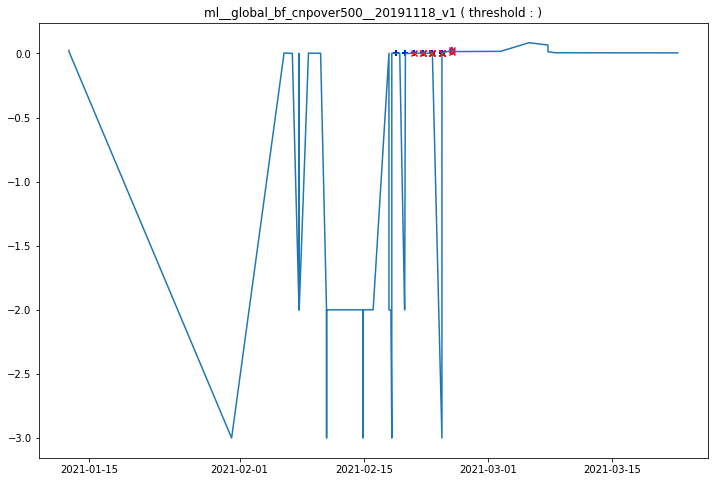

In [29]:

#BF model for card present - threshold - 0.7
df = pull('LVZE61CG7TG3M', '2021-03-31', 'ml__global_bf_cnpover500__20191118_v1')
df['loss_dllr'] = df['loss_dllr'].astype('float',)
df2 = df[df.chargeback_dllr>0]
df3 = df[df.loss_dllr >0]

plt.figure(figsize=(12, 8))
plt.title("ml__global_bf_cnpover500__20191118_v1 ( threshold : )")
plt.plot(df['payment_trx_recognized_at'], df['score'])
plt.scatter(df2['payment_trx_recognized_at'], df2['score'], marker='+',color = 'b')
plt.scatter(df3['payment_trx_recognized_at'], df3['score'], marker='x',color = 'r')

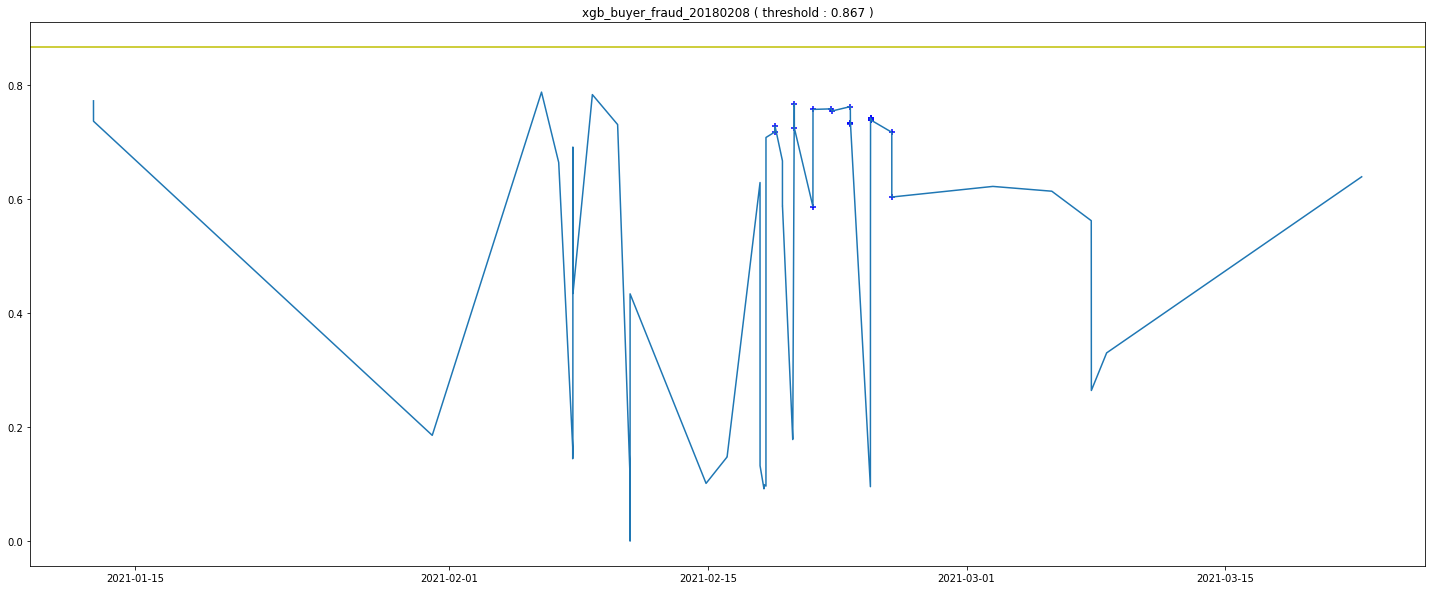

In [30]:

#BF model for card present - threshold - 0.7
df_bf = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_buyer_fraud_20180208')
#globalbf_decline_cnpall_20181122
df_bf['loss_dllr'] = df_bf['loss_dllr'].astype('float',)

df_bf1= df_bf[df_bf['payment_trx_recognized_at']> '2020-12-31 11:59:59']

df_bf2 = df_bf1[df_bf1.chargeback_dllr>0]
df_bf3 = df_bf1[df_bf1.loss_dllr >0]

plt.figure(figsize=(25, 10))
plt.title("xgb_buyer_fraud_20180208 ( threshold : 0.867 )")
plt.plot(df_bf1['payment_trx_recognized_at'], df_bf1['score'])
plt.scatter(df_bf2['payment_trx_recognized_at'], df_bf2['score'], marker='+',color = 'b')
#plt.scatter(df_bf3['payment_trx_recognized_at'], df_bf3['score'], marker='x',color = 'r')

plt.axhline(y=0.867, color='y', linestyle='-')

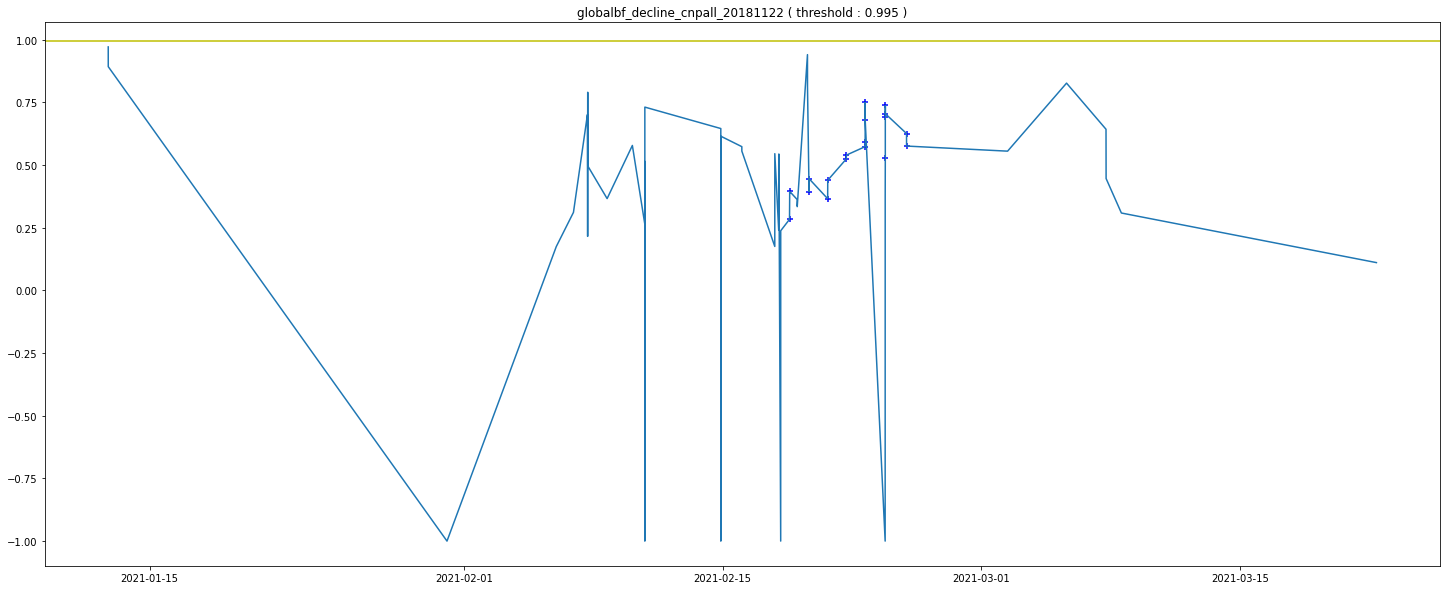

In [19]:
#BF model  - Lower threshold is 0.7 (*but is used only for 1K and above)
df_bf = pull('LVZE61CG7TG3M', '2021-03-31', 'globalbf_decline_cnpall_20181122_v3')
df_bf['loss_dllr'] = df_bf['loss_dllr'].astype('float',)

df_bf1= df_bf[df_bf['payment_trx_recognized_at']> '2020-12-31 11:59:59']

df_bf2 = df_bf1[df_bf1.chargeback_dllr>0]
df_bf3 = df_bf1[df_bf1.loss_dllr >0]

plt.figure(figsize=(25, 10))
plt.title("globalbf_decline_cnpall_20181122 ( threshold : 0.995 )")
plt.plot(df_bf1['payment_trx_recognized_at'], df_bf1['score'])
plt.scatter(df_bf2['payment_trx_recognized_at'], df_bf2['score'], marker='+',color = 'b')
#plt.scatter(df_bf3['payment_trx_recognized_at'], df_bf3['score'], marker='x',color = 'r')

plt.axhline(y=0.995, color='y', linestyle='-')

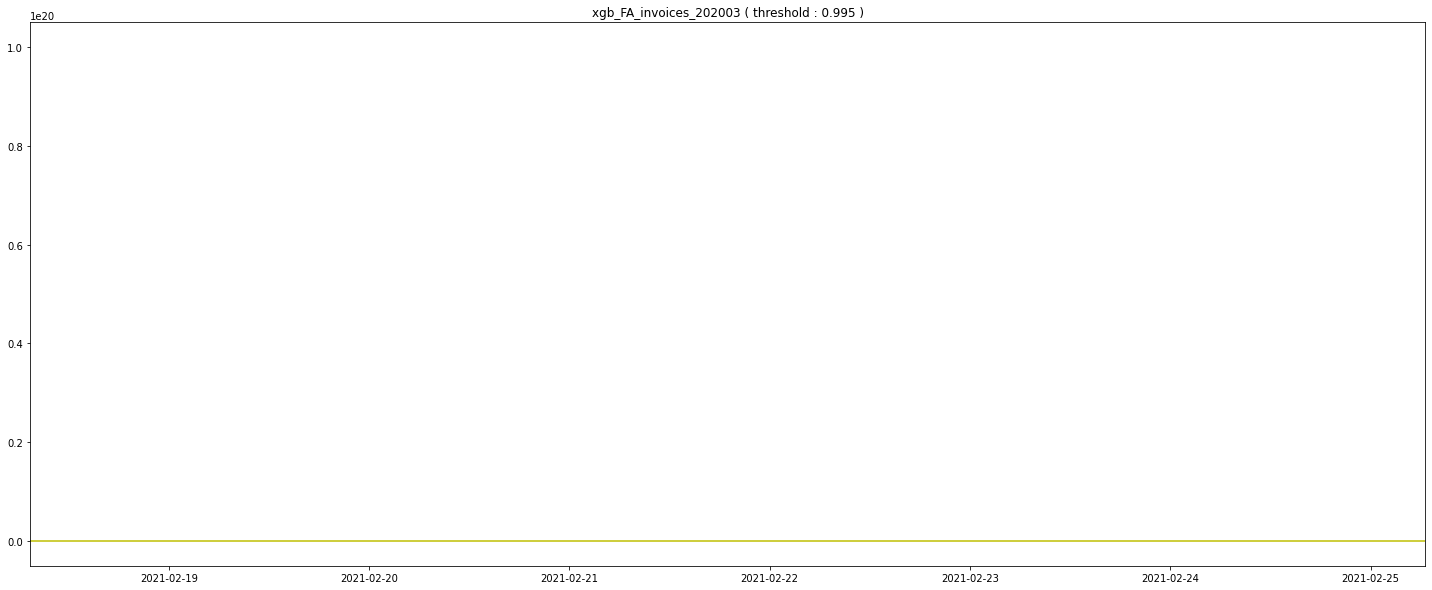

In [31]:
#BF model  - Lower threshold is 0.7 (*but is used only for 1K and above)
df_bf_model = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_FA_invoices_202003')
df_bf_model['loss_dllr'] = df_bf_model['loss_dllr'].astype('float',)

df_bf_model1= df_bf_model[df_bf_model['payment_trx_recognized_at']> '2020-12-31 11:59:59']
df_bf_model2 = df_bf_model1[df_bf_model1.chargeback_dllr>0]
df_bf_model3 = df_bf_model1[df_bf_model1.loss_dllr >0]

plt.figure(figsize=(25, 10))
plt.title("xgb_FA_invoices_202003 ( threshold : 0.995 )")
plt.plot(df_bf_model1['payment_trx_recognized_at'], df_bf_model1['score'])
plt.scatter(df_bf_model2['payment_trx_recognized_at'], df_bf_model2['score'], marker='+',color = 'b')
#plt.scatter(df_bf3['payment_trx_recognized_at'], df_bf3['score'], marker='x',color = 'r')

plt.axhline(y=0.995, color='y', linestyle='-')

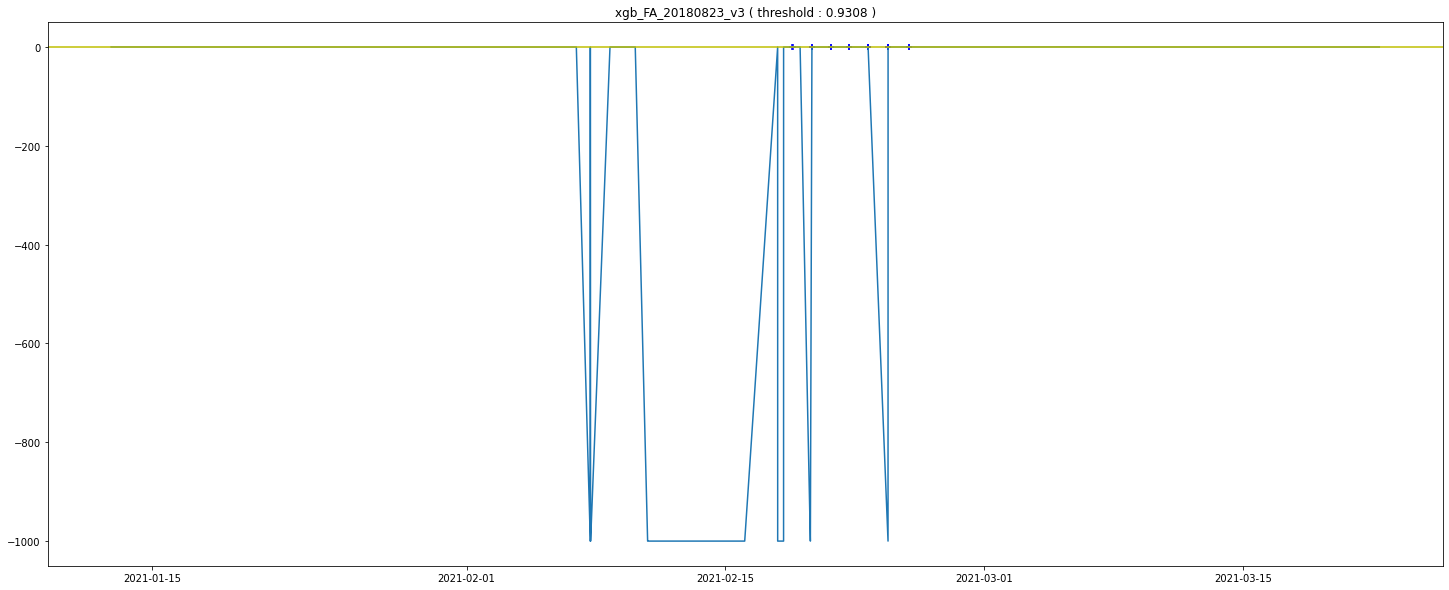

In [32]:

#BF model  - Lower threshold is 0.7 (*but is used only for 1K and above)
df_fa = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_FA_20180823_v3')
df_fa['loss_dllr'] = df_fa['loss_dllr'].astype('float',)

df_fa1= df_fa[df_fa['payment_trx_recognized_at']> '2020-12-31 11:59:59']
df_fa2 = df_fa1[df_fa1.chargeback_dllr>0]
df_fa3 = df_fa1[df_fa1.loss_dllr >0]

plt.figure(figsize=(25, 10))
plt.title("xgb_FA_20180823_v3 ( threshold : 0.9308 )")
plt.plot(df_fa1['payment_trx_recognized_at'], df_fa1['score'])
plt.scatter(df_fa2['payment_trx_recognized_at'], df_fa2['score'], marker='+',color = 'b')
#plt.scatter(df_bf3['payment_trx_recognized_at'], df_bf3['score'], marker='x',color = 'r')

plt.axhline(y=0.9308, color='y', linestyle='-')

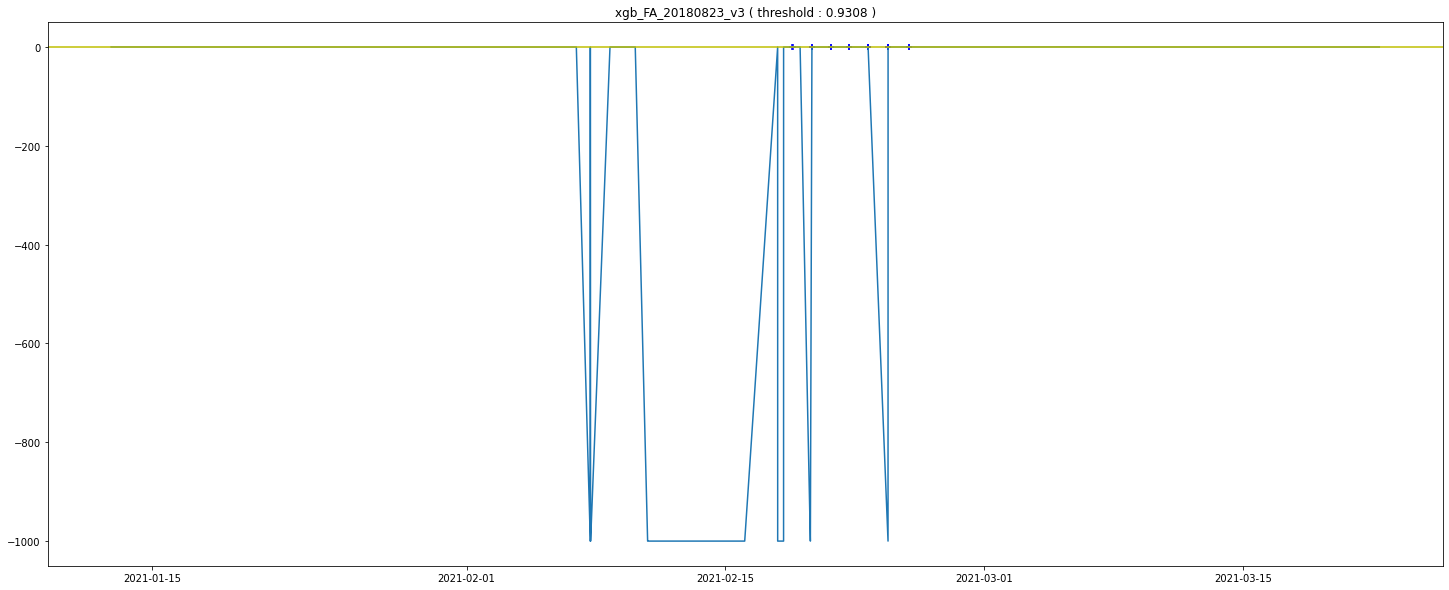

In [33]:


df_fa = pull('LVZE61CG7TG3M', '2021-03-31', 'xgb_FA_20180823_v3')
df_fa['loss_dllr'] = df_fa['loss_dllr'].astype('float',)

df_fa1= df_fa[df_fa['payment_trx_recognized_at']> '2020-12-31 11:59:59']
df_fa2 = df_fa1[df_fa1.chargeback_dllr>0]
df_fa3 = df_fa1[df_fa1.loss_dllr >0]

plt.figure(figsize=(25, 10))
plt.title("xgb_FA_20180823_v3 ( threshold : 0.9308 )")
plt.plot(df_fa1['payment_trx_recognized_at'], df_fa1['score'])
plt.scatter(df_fa2['payment_trx_recognized_at'], df_fa2['score'], marker='+',color = 'b')
#plt.scatter(df_bf3['payment_trx_recognized_at'], df_bf3['score'], marker='x',color = 'r')
# plt.axhline(y=0.997, color='y', linestyle='-', label='Sample Label Red')
plt.axhline(y=0.9308, color='y', linestyle='-')

In [34]:
df_fa

,payment_token,unit_token,amount_base_unit_usd,payment_trx_recognized_at,payment_cnt,modelname,eventkey,score,dmeta_datestring,payment_token,chargeback_dllr,loss_dllr
0,5GB6Qbof74Tks0SmlYUVncYPuaB,LVZE61CG7TG3M,247865,2021-01-12 18:24:09,59,xgb_FA_20180823_v3,5GB6Qbof74Tks0SmlYUVncYPuaB,0.144229,2021-01-12,None,None,NaN
1,PPsqXwgbd6VfBlD6Im3xYmEruaB,LVZE61CG7TG3M,165800,2021-01-12 18:26:22,58,xgb_FA_20180823_v3,PPsqXwgbd6VfBlD6Im3xYmEruaB,0.112454,2021-01-12,None,None,NaN
2,VoTmGQBntWX5b1Cz4rsjoH12uaB,LVZE61CG7TG3M,17200,2021-01-31 02:14:53,57,xgb_FA_20180823_v3,VoTmGQBntWX5b1Cz4rsjoH12uaB,0.003222,2021-01-31,None,None,NaN
3,7PdYJp2LsX1LGL2njDg2gfShuaB,LVZE61CG7TG3M,325700,2021-02-06 00:06:42,56,xgb_FA_20180823_v3,7PdYJp2LsX1LGL2njDg2gfShuaB,0.008354,2021-02-06,None,None,NaN
4,TTp4Pm10QvxIHtZpq0KfKfOauaB,LVZE61CG7TG3M,176200,2021-02-06 22:26:33,55,xgb_FA_20180823_v3,TTp4Pm10QvxIHtZpq0KfKfOauaB,0.000946,2021-02-06,None,None,NaN
5,VmyaqXU8OlxZD4x7zNSqbCRdvaB,LVZE61CG7TG3M,132500,2021-02-07 16:35:05,54,xgb_FA_20180823_v3,VmyaqXU8OlxZD4x7zNSqbCRdvaB,-1000.000000,2021-02-07,None,None,NaN
6,zfhTUZtQdBSC1yRFcfM9XbMfvaB,LVZE61CG7TG3M,175000,2021-02-07 16:37:32,53,xgb_FA_20180823_v3,zfhTUZtQdBSC1yRFcfM9XbMfvaB,0.001645,2021-02-07,None,None,NaN
7,FGmS0ApojN9omDGoGUi1IHKhvaB,LVZE61CG7TG3M,133145,2021-02-07 16:49:25,52,xgb_FA_20180823_v3,FGmS0ApojN9omDGoGUi1IHKhvaB,-1000.000000,2021-02-07,None,None,NaN
8,JkWZPeKW28GuExgvGN2qlKXeuaB,LVZE61CG7TG3M,164200,2021-02-07 16:51:38,51,xgb_FA_20180823_v3,JkWZPeKW28GuExgvGN2qlKXeuaB,-1000.000000,2021-02-07,None,None,NaN
9,DpIMxQjN380NRNL1KyFuc9gXvaB,LVZE61CG7TG3M,215900,2021-02-07 16:58:20,50,xgb_FA_20180823_v3,DpIMxQjN380NRNL1KyFuc9gXvaB,-1000.000000,2021-02-07,None,None,NaN
